# Hazard and Survival

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/AskStatistics/comments/1gzff52/if_i_have_a_tumor_that_ive_been_told_has_a/).

> If I have a tumor that I've been told has a malignancy rate of 2% per year, does that compound? So after 5 years there's a 10% chance it will turn malignant? 

This turns out to be an interesting question, because the answer depends on what that 2% means.
If we know that it's the same for everyone, and it doesn't vary over time, computing the compounded probability after 5 years is a relatively simple.

But if that 2% is an average across people with different probabilities, the computation is a little more complicated -- and the answer turns out to be substantially different, so this is not a negligible effect.

To demonstrate both computations, I'll assume that the probability for a given patient doesn't change over time.
This assumption is consistent with the [multistage model of carcinogenesis](https://en.wikipedia.org/wiki/Armitage%E2%80%93Doll_multistage_model_of_carcinogenesis), which posits that normal cells become cancerous through a series of mutations, where the probability of any of those mutations is constant over time.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/hazard.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py');

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

## Constant Hazard

Let's start with the simpler calculation, where the probability that a tumor progresses to malignancy is known to be 2% per year and constant.
In that case, we can answer OP's question by making a constant hazard function and using it to compute a survival function.

`empiricaldist` provides a `Hazard` object that represents a hazard function.
Here's one where the hazard is 2% per year for 20 years.

In [4]:
from empiricaldist import Hazard

p = 0.02
ts = np.arange(1, 21)
hazard = Hazard(p, ts, name='hazard1')

The probability that a tumor survives a given number of years without progressing is the cumulative product of the complements of the hazard, which we can compute like this.

In [5]:
p_surv = (1 - hazard).cumprod()

`Hazard` provides a `make_surv` method that does this computation and returns a `Surv` object that represents the corresponding survival function.

In [6]:
surv = hazard.make_surv(name='surv1')

Here's what it looks like.

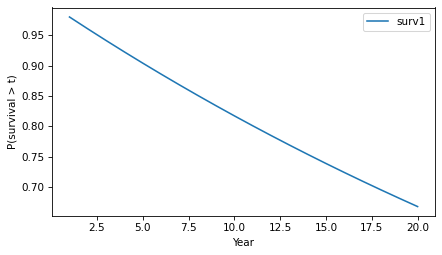

In [7]:
surv.plot()
decorate(xlabel='Year', ylabel='P(survival > t)')

The y-axis shows the probability that a tumor "survives" for more than a given number of years without progressing.
The probability of survival past Year 1 is 98%, as you might expect.

In [8]:
surv.head()

,probs
1,0.980000
2,0.960400
3,0.941192


And the probability of going more than 10 years without progressing is about 82%.

In [9]:
surv(10)

array(0.81707281)

Because of the way the probabilities compound, the survival function drops off with decreasing slope, even though the hazard is constant.

## Knowledge is Power

Now let's add a little more realism to the model.
Suppose that in the observed population the average rate of progression is 2% per year, but it varies from one person to another.
As an example, suppose the actual rate is 1% for half the population and 3% for the other half.
And for a given patient, suppose we don't know initially which group they are in.

[UPDATE: If you read an earlier version of this article, there was an error in this section -- I had the likelihood ratio wrong and it had a substantial effect on the results.]

As in the previous example, the probability that the tumor goes a year without progressing is 98%.
However, at the end of that year, if it has not progressed, we have evidence in favor of the hypothesis that the patient is in the low-progression group.
Specifically, the likelihood ratio is 99/97 in favor of that hypothesis.

Now we can apply [Bayes's rule in odds form](https://en.wikipedia.org/wiki/Bayes'_theorem#Bayes'_rule_in_odds_form).
Since the prior odds were 1:1 and the likelihood ratio is 99/97, the posterior odds are 99:97 -- so after one year we now believe the probability is 50.5% that the patient is in the low-progression group.

In [10]:
p_low = 99 / (99 + 97)
p_low

0.5051020408163265

In that case we can update the probability that the tumor progresses in the second year:

In [11]:
p1 = 0.01
p2 = 0.03

p_low * p1 + (1-p_low) * p2

0.019897959183673472

If the tumor survives a year without progressing, the probability it will progress in the second year is 1.99%, slightly less than the initial estimate of 2%.
Note that this change is due to evidence that the patient is in the low progression group.
It does not assume that anything has changed in the world -- only that we have more information about which world we're in.

If the tumor lasts another year without progressing, we would do the same update again.
The following loop repeats this computation for 20 years.

In [12]:
odds = 1
ratio = 99/97
res = []

for year in hazard.index:
    p_low = odds / (odds + 1)
    haz = p_low * p1 + (1-p_low) * p2
    res.append((p_low, haz))
    odds *= ratio

Here are the results in percentages.

In [13]:
df = pd.DataFrame(res, columns=['p_low', 'hazard'], index=hazard.index)
(df * 100).round(2).head()

,p_low,hazard
1,50.00,2.00
2,50.51,1.99
3,51.02,1.98
4,51.53,1.97
5,52.04,1.96


If we put the hazard rates in a `Hazard` object, we can compare them to the constant hazard model.

In [14]:
hazard2 = Hazard(df['hazard'], name='hazard2')

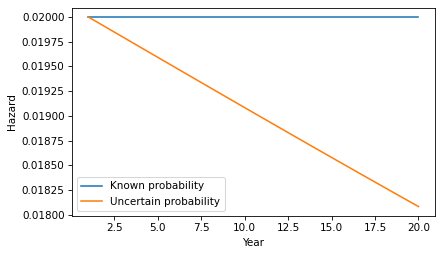

In [15]:
hazard.plot(label='Known probability')
hazard2.plot(label='Uncertain probability')
decorate(xlabel='Year', ylabel='Hazard')

Each year, the probability increases that the patient is in the low-progression group, so the probability of progressing in the next year is a little lower.

Here's what the corresponding survival function looks like.

In [16]:
surv2 = hazard2.make_surv(name='surv2')

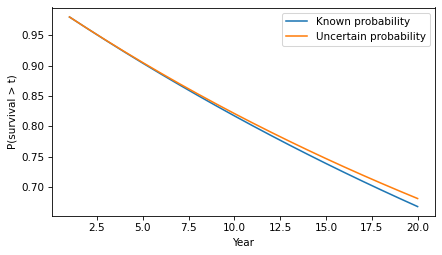

In [17]:
surv.plot(label='Known probability')
surv2.plot(label='Uncertain probability')
decorate(xlabel='Year', ylabel='P(survival > t)')

The difference in survival is small, but it accumulates over time.
For example, the probability of going more than 20 years without progression increases from 67% to 68%.

In [18]:
surv(20), surv2(20)

(array(0.66760797), array(0.68085064))

In this example, there are only two groups with different probabilities of progression.
But we would see the same effect in a more realistic model with a range of probabilities.
As time passes without progression, it becomes more likely that the patient is in a low-progression group, so their hazard during the next period is lower.
The more variability there is in the probability of progression, the stronger this effect.

## Discussion

This example demonstrates a subtle point about a distribution of probabilities.
To explain it, let's consider a more abstract scenario.
Suppose you have two coin-flipping devices:

* One of them is known to flips head and tails with equal probability.

* The other is known to be miscalibrated so it flips heads with either 60% probability or 40% probability -- and we don't know which, but they are equally likely.

If we use the first device, the probability of heads is 50%.
If we use the second device, the probability of heads is 50%.
So it might seem like there is no difference between them -- and more generally, it might seem like we can always collapse a distribution of probabilities down to a single probability.

But that's not true, as we can demonstrate by running the coin-flippers twice.
For the first, the probability of two heads is 25%.
For the second, it's either 36% or 16% with equal probability -- so the total probability is 26%.

In [19]:
p1, p2 = 0.6, 0.4
np.mean([p1**2, p2**2])

0.26

In general, there's a difference between a scenario where a probability is known precisely and a scenario where there is uncertainty about the probability.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)